# Topic Modelling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
from pprint import pprint

/usr/local/lib/python3.9/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.9/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(sentence):
    # Lowercase
    sentence = sentence.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
    sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = re.sub(r'https\S+', '', sentence)
    # Remove double spacing
    sentence = re.sub('\s+', ' ', sentence)
    
    # Tokenize & remove stop-words
    word_list = nltk.word_tokenize(sentence)    
    stopwords_list = nltk.corpus.stopwords.words('english')
    stopwords_list.extend(['thank','today','join','astrazeneca','pfizer','biogen','johnson','amp','gsk','jnj','lt'])
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # Remove very small words, length < 3, they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 3]
        
    # Stem & Lemmatize
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = [porter_stemmer.stem(word) for word in word_list]
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    
    sentence = ' '.join(word_list)
    
    return sentence

<>:11: DeprecationWarning: invalid escape sequence \s
<>:11: DeprecationWarning: invalid escape sequence \s
<ipython-input-21-525ce39ac894>:11: DeprecationWarning: invalid escape sequence \s
  sentence = re.sub('\s+', ' ', sentence)


In [ ]:
# Constants
PHARMA_PATH = '../../data/twitter/pharma companies'
GOVT_INSTITUTES_PATH = '../../data/twitter/govt institutes'
NGO_PATH = '/content/drive/MyDrive/Project 2/data/ngo_who/'+'WHO'+'.csv'

EPOCHS = 205
TOPICS = 5
CHUNK_SIZE = 1000
WORKERS = 7
EVAL_PERIOD = 10
ALPHA = 0.01
BETA = 0.9

In [ ]:
df = pd.concat(map(pd.read_csv, [NGO_PATH]), ignore_index=True)

print(df.shape)

(25989, 13)


In [ ]:
# Convert 'created_at' column to datetime
df['created_at'] = df['created_at'].str[:-6]
df['created_at'] = pd.to_datetime(df['created_at'])

# Sort by datetime ascending
df = df.sort_values(by='created_at')

# Pre-process the dataset
tqdm.tqdm.pandas()
df['tweet_tokenized'] = df['tweet'].progress_apply(lambda x:preprocess_text(str(x)))

100%|██████████| 25989/25989 [00:32<00:00, 791.30it/s]


Generate TF-IDF

In [ ]:
documents = df['tweet_tokenized'].str.split()
dictionary = gensim.corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)

tfidf_model = gensim.models.TfidfModel(dictionary=dictionary)

corpus = [dictionary.doc2bow(d) for d in documents]
corpus_tfidf = list(tfidf_model[corpus])
performance_metrics = pd.DataFrame(columns=['feature-extraction','clustering-algo','run#', 'state', 'c_v', 'c_umass','topics','time'])

LDA

In [ ]:
for run, state in zip(range(2, 3, 1), range(4, 6, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, 
                                                     eval_every = EVAL_PERIOD, per_word_topics=True, random_state=state, alpha=ALPHA, eta=BETA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lda, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lda.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 2


<ipython-input-11-0fc48290541a>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LDA', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


NMF

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_nmf = gensim.models.Nmf(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE, passes=EPOCHS, eval_every=EVAL_PERIOD, minimum_probability=0, 
                                   random_state=state, kappa=1)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_nmf, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_nmf.print_topics()
    
    stop = time.time()
    
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-14-5c68f8286f4d>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'NMF', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


LSI

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_lsi = gensim.models.LsiModel(corpus=corpus_tfidf, num_topics=TOPICS, id2word=dictionary, chunksize=CHUNK_SIZE)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_lsi, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_lsi.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-16-88e3d624a2bc>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'LSI', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


HDP

In [ ]:
for run, state in zip(range(1, 2, 1), range(2, 4, 2)):
    print('Run #', run)
    
    start = time.time()
    gensim_hdp = gensim.models.hdpmodel.HdpModel(corpus=corpus_tfidf, id2word=dictionary, chunksize=CHUNK_SIZE, random_state=state, kappa=1, alpha=ALPHA)
    
    coherence_cv = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_cumass = gensim.models.CoherenceModel(model=gensim_hdp, texts=documents, dictionary=dictionary, coherence='u_mass').get_coherence()
    topics = gensim_hdp.print_topics()
    stop = time.time()
      
    performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,
                                                      'topics':topics,'time':(stop-start)}, ignore_index=True)

Run # 1


<ipython-input-18-b61ff710b833>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_metrics = performance_metrics.append({'feature-extraction':'tf-idf', 'clustering-algo':'HDP', 'run#':run, 'state':state,'c_v':coherence_cv,'c_umass':coherence_cumass,


In [ ]:
performance_metrics.to_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-modelling/who-lda-nmf-lsi-hdp.csv',index=False)

# Topic Propagation

In [ ]:
import glob
import numpy as np
import pandas as pd
import re
import ast

In [ ]:
topic_df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-keywords/topic-keywords-who.csv')

In [ ]:
def isPhraseIn(phrase, text):
    '''
    Returns a boolean value testifying if the phrase exists in the tweet
    '''
    return re.search(r"\b{}\b".format(phrase), text, re.IGNORECASE) is not None

In [ ]:
user_topic_df = pd.DataFrame(columns=['username','topic','tweetCount'])
GOVT_INSTITUTES_PATH = '/content/drive/MyDrive/Project 2/data/ngo_who'
for file in glob.glob(GOVT_INSTITUTES_PATH + "/*.csv"):
    user_df = pd.read_csv(file)
    username = user_df['username'].unique()[0]
    
   
    print('='*100)
    print('2020-2022: ', username)
    for topic_index, topic_row in topic_df[topic_df['time-phase']=='X'].iterrows():
        topic = topic_row['topic']
        # print(topic)
        keywords = ast.literal_eval(topic_row['topic-keywords'])
        # print(keywords)
        topic_user_tweet_count = 0
        
        for index, row in user_df.iterrows():
            for phrase in keywords:
                # print(phrase)
                if(isinstance(row.tweet, float)):
                    row.tweet = str(row.tweet)
                if phrase in row.tweet:                    
                    topic_user_tweet_count += 1
        
        print(topic, topic_user_tweet_count)
        
        user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)
    
# pre_covid_topic_df.to_csv('pre-covid-pharma-companies.csv', index=False)
user_topic_df.to_csv('topic-propagation-who.csv', index=False)

2020-2022:  WHO
World Regions 4097


<ipython-input-5-9c55cdd635a2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


COVID-19 7165


<ipython-input-5-9c55cdd635a2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Community Healthcare 11486


<ipython-input-5-9c55cdd635a2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


General Health 8473


<ipython-input-5-9c55cdd635a2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


Leadership 1646


<ipython-input-5-9c55cdd635a2>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  user_topic_df = user_topic_df.append({'organization':username, 'topic':topic, 'tweetCount':topic_user_tweet_count}, ignore_index=True)


# Heatmaps

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing
import seaborn as sns
import textwrap

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Project 2/results/content-analysis/topic-propagation/topic-propagation-who.csv')
df.set_index('Org', inplace=True)

In [ ]:
df

World Regions  COVID-19  Community Healthcare  General Health  Leadership
Org                                                                           
WHO           4097      7165                 11486            8473        1646

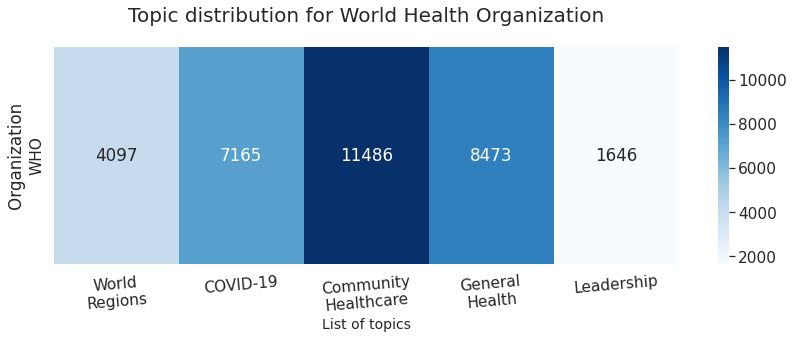

In [ ]:
plt.figure(figsize = (14,4))
plt.rcParams['axes.titlepad'] = 25
sns.set(font_scale=1.4)

# ax = sns.heatmap(df, annot=True, cmap='Blues',fmt='g')
ax = sns.heatmap(df, annot=True, cmap='Blues', fmt='g')
plt.title('Topic distribution for World Health Organization', fontdict={'fontsize':20})
plt.xlabel('List of topics')
plt.ylabel('Organization')
ax.xaxis.label.set_size(14)
ax.set_xticklabels(textwrap.fill(x.get_text(), 11) for x in ax.get_xticklabels())
plt.xticks(rotation=5)
plt.savefig('pharmaceutical-companies.pdf', transparent=True, bbox_inches='tight')
plt.savefig('pharmaceutical-companies.png', transparent=True, bbox_inches='tight')
plt.show()

# Hashtags & Mentions

In [ ]:
!pip install advertools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.9/272.9 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 KB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import tqdm
import nltk
import re
from operator import itemgetter
import time
import advertools as adv
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def remove_tags(tweet):
    return re.sub('#dyk|#unsubscribe','',tweet)

In [ ]:
def hashtags(data,column):
    hashtag_summary = adv.extract_hashtags(data[column].astype('str').values.tolist()) 
    # print(hashtag_summary['top_hashtags'][:10]][::-1])   
    plt.figure(figsize=(14, 6))
    plt.barh([x[0] for x in hashtag_summary['top_hashtags'][:10]][::-1],
         [x[1] for x in hashtag_summary['top_hashtags'][:10]][::-1])
    plt.title('Top Hashtags for {}'.format(data.name))
    plt.show()
    print(hashtag_summary['top_hashtags'][:10])
    return print("hashtag_overview:",hashtag_summary['overview'])
def mentions(data,column):
  mention_summary = adv.extract_mentions(data[column].astype('str').values.tolist())
  plt.figure(figsize=(15,6))
  plt.barh([x[0] for x in mention_summary['top_mentions'][:10]][::-1],
        [x[1] for x in mention_summary['top_mentions'][:10]][::-1])
  plt.title('Top Mentions for {}'.format(data.name))
  plt.show()
  print(mention_summary['top_mentions'][:10])
  return print("overview:",mention_summary['overview'])

In [ ]:
PATH = '/content/drive/MyDrive/Project 2/data/ngo_who'

In [ ]:
df = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob(PATH + "/*.csv")],ignore_index=True)
df['name'] = 'WHO'


In [ ]:
# Convert 'created_at' column to datetime
df['created_at'] = df['created_at'].str[:-6]
df['created_at'] = pd.to_datetime(df['created_at'])

# Sort by datetime ascending
df = df.sort_values(by='created_at')

df['tweet'] = df['tweet'].str.replace('#jnj|#dyk|#stop|#wha73|#unsubscribe','',regex=True,case=False)

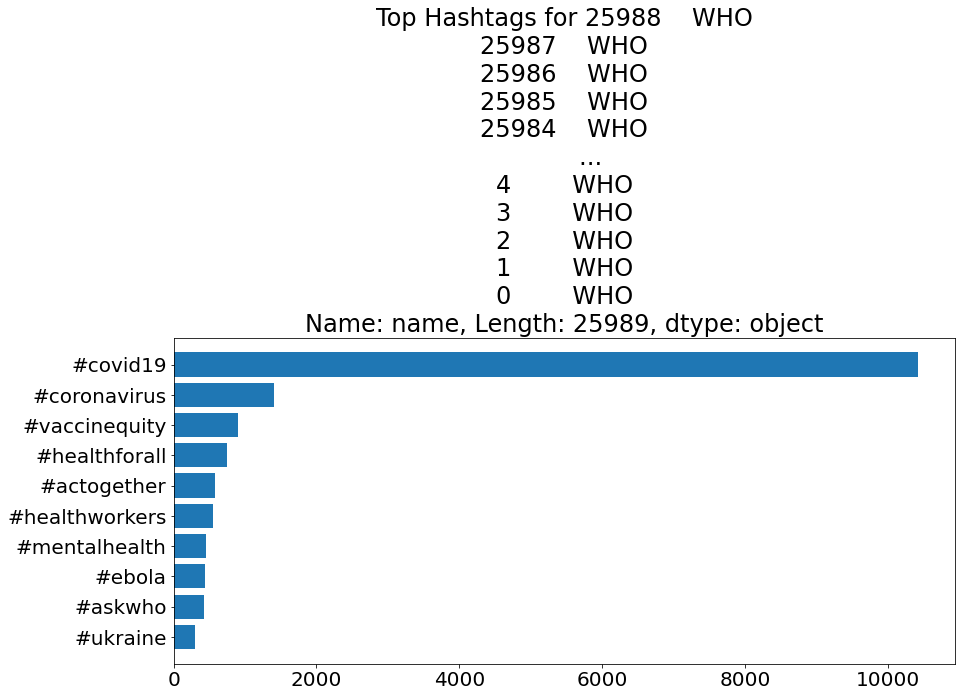

[('#covid19', 10415), ('#coronavirus', 1404), ('#vaccinequity', 897), ('#healthforall', 753), ('#actogether', 575), ('#healthworkers', 553), ('#mentalhealth', 447), ('#ebola', 442), ('#askwho', 419), ('#ukraine', 305)]
hashtag_overview: {'num_posts': 25989, 'num_hashtags': 32819, 'hashtags_per_post': 1.2628034937858326, 'unique_hashtags': 1385}


In [ ]:
hashtags(df, 'tweet')

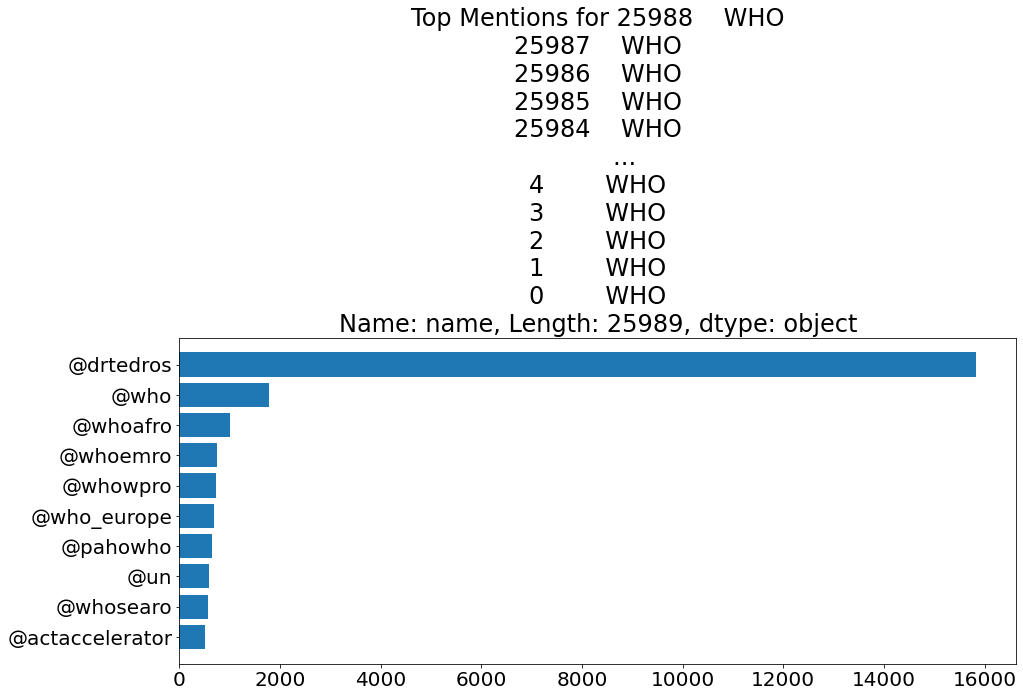

[('@drtedros', 15839), ('@who', 1790), ('@whoafro', 1006), ('@whoemro', 740), ('@whowpro', 727), ('@who_europe', 689), ('@pahowho', 653), ('@un', 596), ('@whosearo', 570), ('@actaccelerator', 504)]
overview: {'num_posts': 25989, 'num_mentions': 33650, 'mentions_per_post': 1.2947785601600676, 'unique_mentions': 1541}


In [ ]:
mentions(df,'tweet')

#Pre-processing

In [ ]:
 !pip install -qq -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy
from numpy.random import randint
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from mlxtend.frequent_patterns import association_rules
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from networkx.algorithms.flow import shortest_augmenting_path
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
PORTER_STEMMER = PorterStemmer()

In [ ]:
pharma_username = ['pfizer']
#'JNJNews', 'AstraZeneca', 'GSK', 'Novartis'
public_username = ['CDCgov', 'IHSgov', 'GovCanHealth', 'GCIndigenous']
ngo_username = ['WHO']

In [ ]:

file2 = '/content/drive/MyDrive/Project 2/data/public_health_Agencies/'+'Novartis'+'.csv'
file3 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'JNJNews'+'.csv'
file4 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'GSK'+'.csv'
file5 = '/content/drive/MyDrive/Project 2/data/pharma_companies/'+'AstraZeneca'+'.csv'
Sample_Tweets = pd.concat(
map(pd.read_csv, [file2, file3, file4, file5]), ignore_index=True)
print(Sample_Tweets)
# dataFrame.to_csv('/content/drive/MyDrive/Project 2/gephi/public_health_agencies/public_merged.csv')

                        id                 created_at      conversation_id  \
0      1609252185367363584  2022-12-31 18:16:34+00:00  1609252185367363584   
1      1609171849719455744  2022-12-31 12:57:20+00:00  1609171849719455744   
2      1609136658598821888  2022-12-31 10:37:30+00:00  1609136658598821888   
3      1609100260768448513  2022-12-31 08:12:52+00:00  1608375792152477697   
4      1608957313620267008  2022-12-30 22:44:51+00:00  1608953905584705536   
...                    ...                        ...                  ...   
25984  1212432462422392838  2020-01-01 17:56:39+00:00  1212432462422392838   
25985  1212412667073302528  2020-01-01 16:38:00+00:00  1211948316570849281   
25986  1212403167931125761  2020-01-01 16:00:15+00:00  1212403167931125761   
25987  1212393982665404416  2020-01-01 15:23:45+00:00  1211948316570849281   
25988  1212346627165478914  2020-01-01 12:15:34+00:00  1211948316570849281   

                                                   tweet  retwe

In [ ]:
stopwords_df = set(nltk.corpus.stopwords.words("english"));
stopwords_df.add("nlet")
stopwords_df.add("choose")
# stopwords_df.add("amp")
# stopwords_df.add("get")
# stopwords_df.add("It")
print(stopwords_df)

{"shan't", 'because', 'them', 'again', "mightn't", 'haven', 'most', 'in', 'where', 'yours', 'nor', "hasn't", 'below', "wouldn't", "that'll", 'being', 'from', 'up', 'as', 'this', "you'd", 'm', "won't", 'while', 'own', 'won', 'mightn', 'under', "you'll", 'how', 'on', 'for', 'why', 'its', 'during', 'these', 'and', "you've", "couldn't", 'we', 'into', 'himself', 'than', 'shouldn', 'it', "hadn't", 'ain', 'only', 'few', 'same', 'who', "needn't", 'o', 'my', 'if', 'her', 'once', 'out', 'doesn', 'some', 'over', 'ma', 'our', 'doing', 'or', 'further', 'after', 'all', 'such', 't', 'will', 're', "weren't", 'at', "didn't", "aren't", 'couldn', 'both', 'needn', 'theirs', 'shan', 'those', 'hadn', 'not', 'be', 'other', 'am', 'having', 'd', 'here', 'too', 'herself', 'weren', 'their', 'off', 'had', 'the', 'so', 'but', 'nlet', 'itself', 'has', 'against', 'hasn', 'was', 'isn', "shouldn't", "isn't", 'through', 'you', 'been', 'to', 'when', "mustn't", 've', "haven't", 'any', 'then', "doesn't", "you're", 'is', '

#Word Cloud

In [ ]:
df = None
Tweet_Texts=Sample_Tweets['tweet'].values

# Converting the text column as a single string for wordcloud
Tweets_String=str(Tweet_Texts)

# Tweet Text cleaning
import re

# Converting the whole text to lowercase
Tweet_Texts_Cleaned = Tweets_String.lower()

# Removing the twitter usernames from tweet string
Tweet_Texts_Cleaned=re.sub(r'@\w+', ' ', Tweet_Texts_Cleaned)

# Removing the URLS from the tweet string
Tweet_Texts_Cleaned=re.sub(r'http\S+', ' ', Tweet_Texts_Cleaned)


# Deleting everything which is not characters
Tweet_Texts_Cleaned = re.sub(r'[^a-z A-Z]', ' ',Tweet_Texts_Cleaned)

# Deleting any word which is less than 3-characters mostly those are stopwords
Tweet_Texts_Cleaned= re.sub(r'\b\w{1,2}\b', '', Tweet_Texts_Cleaned)

# Stripping extra spaces in the text
Tweet_Texts_Cleaned= re.sub(r' +', ' ', Tweet_Texts_Cleaned)

Tweet_Texts_Cleaned


' those who have health have hope and those who have hope have everything wish you full health and hope nlet choose hope together nlet choose better future together nlet choose healthforall together congratulations the well deserved knighthood recognition his majesty the king gra happynewyear nto achieve healthforall the will need million more nurses and midwives urging countries healthy resolution limit use alcohol happynewyear healthy resolution say notobacco happynewyear '

In [ ]:
print(Tweet_Texts_Cleaned)

 those who have health have hope and those who have hope have everything wish you full health and hope nlet choose hope together nlet choose better future together nlet choose healthforall together congratulations the well deserved knighthood recognition his majesty the king gra happynewyear nto achieve healthforall the will need million more nurses and midwives urging countries healthy resolution limit use alcohol happynewyear healthy resolution say notobacco happynewyear 


/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


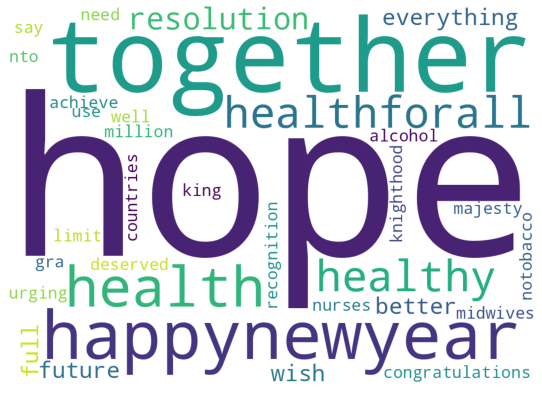

In [ ]:
# Plotting the wordcloud 
# you can specify fonts, stopwords, background color and other options
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Creating the custom stopwords
customStopwords=list(stopwords_df)

wordcloudimage = WordCloud(
                          max_words=100,
                          max_font_size=500,
                          font_step=2,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts_Cleaned)

plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

#ARM (Itemsets)

In [ ]:
len(pd.read_csv(file1))

25989

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
def clean_tweets(x, STOPWORDS):
    # Lowercase
    sentence = x.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub('http[s]?://\S+', '', sentence)
    sentence = re.sub(r'([^a-zA-Z ]+?)', '', sentence)
    #print(sentence)
    #sentence = sentence.replace('\n', '')
    # Remove URLs
    sentence = sentence.replace("world health organization", "who")
    #print(sentence)
    # Remove double spacing
    #sentence = re.sub('\s+', ' ', sentence)
    tokenized_tweet = [word for word in word_tokenize(sentence) if word not in STOPWORDS]
    tokenized_tweet = [PORTER_STEMMER.stem(word) for word in tokenized_tweet]
    return tokenized_tweet

<>:6: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \S
<ipython-input-10-e9114ee358bb>:6: DeprecationWarning: invalid escape sequence \S
  sentence = re.sub('http[s]?://\S+', '', sentence)


In [ ]:
df = Sample_Tweets
  
#clean tweets
from tqdm.notebook import tqdm
tqdm.pandas()
df["tokenized_tweet"] = df["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))
tokenized_tweets = df["tokenized_tweet"].values.tolist()
te = TransactionEncoder()
te_ary = te.fit(tokenized_tweets).transform(tokenized_tweets)
df = pd.DataFrame(te_ary, columns=te.columns_)


  

  0%|          | 0/25989 [00:00<?, ?it/s]

In [ ]:
df

aamir   aamp  aarogya  aastabilisiert  aavitsland  aazoulay     ab  \
0      False  False    False           False       False     False  False   
1      False  False    False           False       False     False  False   
2      False  False    False           False       False     False  False   
3      False  False    False           False       False     False  False   
4      False  False    False           False       False     False  False   
...      ...    ...      ...             ...         ...       ...    ...   
25984  False  False    False           False       False     False  False   
25985  False  False    False           False       False     False  False   
25986  False  False    False           False       False     False  False   
25987  False  False    False           False       False     False  False   
25988  False  False    False           False       False     False  False   

       ababa  abahuy  abaixo  ...  zourabichvili  zsuzsanna     zu  zubair  \
0      False   False   False  ...          False      False  False   False   
1      False   False   False  ...          False      False  False   False   
2      False   False   False  ...          False      False  False   False   
3      False   False   False  ...          False      False  False   False   
4      False   False   False  ...          False      False  False   False   
...      ...     ...     ...  ...            ...        ...    ...     ...   
25984  False   False   False  ...          False      False  False   False   
25985  False   False   False  ...          False      False  False   False   
25986  False   False   False  ...          False      False  False   False   
25987  False   False   False  ...          False      False  False   False   
25988  False   False   False  ...          False      False  False   False   

       zuckerberg  zugang  zulusign  zunyou    zur     zz  
0           False   False     False   False  False  False  
1           False   False     False   False  False  False  
2           False   False     False   False  False  False  
3           False   False     False   False  False  False  
4           False   False     False   False  False  False  
...           ...     ...       ...     ...    ...    ...  
25984       False   False     False   False  False  False  
25985       False   False     False   False  False  False  
25986       False   False     False   False  False  False  
25987       False   False     False   False  False  False  
25988       False   False     False   False  False  False  

[25989 rows x 25677 columns]

In [ ]:
#Itemsets


min_sup=0.5
frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
print("len of frequent itemsets: ", len(frequent_itemsets.index))

while(len(frequent_itemsets.index)<100):
  min_sup = min_sup/2
  frequent_itemsets = apriori(df, min_support=min_sup, use_colnames=True)
  print("len of frequent itemsets: ", len(frequent_itemsets.index))

itemsets_df = frequent_itemsets[:100] 
print(itemsets_df)
itemsets_df.to_csv("itemsets.csv");



len of frequent itemsets:  0
len of frequent itemsets:  3
len of frequent itemsets:  7
len of frequent itemsets:  23
len of frequent itemsets:  87
len of frequent itemsets:  343
     support      itemsets
0   0.052869      (access)
1   0.017238      (achiev)
2   0.020624  (actacceler)
3   0.021086      (action)
4   0.021317    (actogeth)
..       ...           ...
95  0.015699        (part)
96  0.027589     (partner)
97  0.020008     (patient)
98  0.113202       (peopl)
99  0.017161      (person)

[100 rows x 2 columns]


#ARM (Rules)

In [ ]:
matrix_df = pd.DataFrame(columns=['Threshold Support', 'Threshold Confidence', 'Count of rules'])
for min_support_initialize in np.arange(0.01, 0.015, 0.001): #0.125, 0.5, 0.0625
  for min_threshold_initialize in np.arange(0.5, 1, 0.1):
    frequent_itemsets_temp = apriori(df, min_support=min_support_initialize, use_colnames=True)
    if(frequent_itemsets_temp.empty):
      continue
    rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=min_threshold_initialize)
  # rules = rules.sort_values(by='confidence', ascending =False)
  # print(rules)
    matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
  
print(matrix_df)

    Threshold Support  Threshold Confidence  Count of rules
0               0.010                   0.5           682.0
1               0.010                   0.6           645.0
2               0.010                   0.7           523.0
3               0.010                   0.8           466.0
4               0.010                   0.9           406.0
5               0.011                   0.5           651.0
6               0.011                   0.6           624.0
7               0.011                   0.7           508.0
8               0.011                   0.8           459.0
9               0.011                   0.9           403.0
10              0.012                   0.5           641.0
11              0.012                   0.6           617.0
12              0.012                   0.7           502.0
13              0.012                   0.8           456.0
14              0.012                   0.9           403.0
15              0.013                   

In [ ]:
matrix_df.to_csv('Support vs Confidence for WHO.csv')

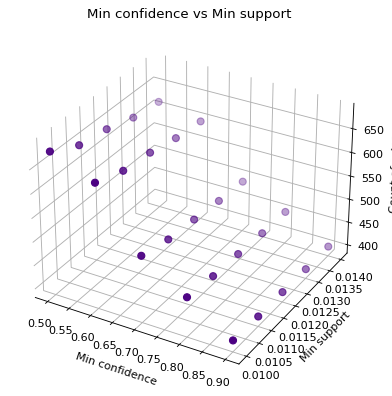

In [ ]:
from IPython.core.pylabtools import figsize
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import itertools
fig = plt.figure(figsize=(8, 6), dpi=80)

# syntax for 3-D projection
ax = plt.axes(projection ='3d', )

# defining all 3 axes
z = matrix_df['Count of rules']
x = matrix_df['Threshold Confidence']
y = matrix_df['Threshold Support']

# plotting

ax.scatter(x, y, z, color='indigo', s=40)
ax.set_title('Min confidence vs Min support')
ax.set_xlabel('Min confidence')
ax.set_ylabel('Min support')

# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# ax.grid(False)

ax.set_zlabel('Count of rules')
plt.show()


In [ ]:
# 0              0.1250                   0.5           101.0

# 4              0.01                   0.8         0
frequent_itemsets_temp = apriori(df, min_support=0.015, use_colnames=True)

rules = association_rules(frequent_itemsets_temp, metric="confidence", min_threshold=0.8)
rules[rules['lift']>=1]
print(rules)

             antecedents                                     consequents  \
0               (public)                                        (health)   
1               (worker)                                        (health)   
2             (whosearo)                                       (pahowho)   
3             (whosearo)                                       (whoafro)   
4             (whosearo)                                       (whoemro)   
..                   ...                                             ...   
446   (whoemro, whowpro)          (whosearo, whoeurop, pahowho, whoafro)   
447  (pahowho, whoeurop)           (whosearo, whoemro, whoafro, whowpro)   
448  (whoeurop, whowpro)           (whosearo, pahowho, whoemro, whoafro)   
449   (pahowho, whowpro)          (whosearo, whoeurop, whoemro, whoafro)   
450           (whosearo)  (whoafro, whoemro, whoeurop, pahowho, whowpro)   

     antecedent support  consequent support   support  confidence       lift  \
0      

In [ ]:
rules.to_csv('/content/drive/MyDrive/Project 2/results/ngo_who/'+'WHO'+'.csv')

In [ ]:
type(rules)

pandas.core.frame.DataFrame

In [ ]:
rules

antecedents                                     consequents  \
0               (public)                                        (health)   
1               (worker)                                        (health)   
2             (whosearo)                                       (pahowho)   
3             (whosearo)                                       (whoafro)   
4             (whosearo)                                       (whoemro)   
..                   ...                                             ...   
446   (whoemro, whowpro)          (whosearo, whoeurop, pahowho, whoafro)   
447  (pahowho, whoeurop)           (whosearo, whoemro, whoafro, whowpro)   
448  (whoeurop, whowpro)           (whosearo, pahowho, whoemro, whoafro)   
449   (pahowho, whowpro)          (whosearo, whoeurop, whoemro, whoafro)   
450           (whosearo)  (whoafro, whoemro, whoeurop, pahowho, whowpro)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.038170            0.234291  0.030590    0.801411   3.420574   
1              0.023933            0.234291  0.020432    0.853698   3.643743   
2              0.021778            0.024895  0.018123    0.832155  33.426412   
3              0.021778            0.036054  0.018008    0.826855  22.933978   
4              0.021778            0.027935  0.017892    0.821555  29.409624   
..                  ...                 ...       ...         ...        ...   
446            0.017854            0.017892  0.017854    1.000000  55.890323   
447            0.019162            0.017854  0.017854    0.931727  52.186747   
448            0.017931            0.017892  0.017854    0.995708  55.650450   
449            0.018200            0.017892  0.017854    0.980973  54.826870   
450            0.021778            0.017854  0.017854    0.819788  45.916961   

     leverage  conviction  
0    0.021647    3.855751  
1    0.014824    5.233744  
2    0.017581    5.809572  
3    0.017222    5.567282  
4    0.017284    5.447414  
..        ...         ...  
446  0.017534         inf  
447  0.017512   14.385555  
448  0.017533  228.831121  
449  0.017528   51.615222  
450  0.017465    5.449949  

[451 rows x 9 columns]

In [ ]:
df1 = (rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))
df1.to_csv('/content/drive/MyDrive/Project 2/results/ngo_who/'+'WHO'+'.csv')

#Metrics
Recommender systems can also profit from the messages shared on social media 

The higher the popularity of a tweet, the more likely it is to contain highly supported association rule.




In [ ]:
Sample_Tweets['Tweet_popularity'] = Sample_Tweets['retweet_count']

In [ ]:
Sample_Tweets = Sample_Tweets.sort_values(by=['Tweet_popularity'], ascending=False)


In [ ]:
Sample_Tweets["tokenized_tweet"] = Sample_Tweets["tweet"].progress_apply(lambda x : clean_tweets(x, stopwords_df))


  0%|          | 0/25989 [00:00<?, ?it/s]

In [ ]:
Sample_Tweets

id                 created_at      conversation_id  \
23447  1237777021742338049  2020-03-11 16:26:53+00:00  1237774421307228160   
17838  1297527275781599235  2020-08-23 13:33:04+00:00  1297527275781599235   
9394   1413965017385521152  2021-07-10 20:55:05+00:00  1413965017385521152   
22748  1244192296922501122  2020-03-29 09:18:54+00:00  1244192296922501122   
22760  1243972193169616898  2020-03-28 18:44:17+00:00  1243972193169616898   
...                    ...                        ...                  ...   
22399  1247525983101440000  2020-04-07 14:05:46+00:00  1247525983101440000   
2758   1530156222917246977  2022-05-27 11:57:27+00:00  1530156222917246977   
25373  1220691471373869056  2020-01-24 12:55:00+00:00  1220691471373869056   
20534  1262742422582226948  2020-05-19 13:50:28+00:00  1262742422582226948   
2592   1533925446143852546  2022-06-06 21:34:59+00:00  1533894279181086725   

                                                   tweet  retweet_count  \
23447  🚨 BREAKING 🚨\n\n"We have therefore made the as...          50126   
17838  RT @DrTedros: I hear you and all the other #BT...          46048   
9394   RT @DrTedros: Thank you, @BTS_twt, for includi...          39366   
22748  RT @WHO: FACT: #COVID19 is NOT airborne. \n\nT...          38845   
22760  FACT: #COVID19 is NOT airborne. \n\nThe #coron...          38845   
...                                                  ...            ...   
22399  Face masks alone cannot protect you from #COVI...              0   
2758                             https://t.co/djD21uJUiZ              0   
25373                            https://t.co/ySsm1n9LGw              0   
20534                            https://t.co/C7q61yGb8r              0   
2592   @RealBCThinkTank @PeopleDocGeneva Thank you fo...              0   

       like_count  reply_count  quote_count  \
23447       51427         1972        13227   
17838           0            0            0   
9394            0            0            0   
22748           0            0            0   
22760       43414         2904         4507   
...           ...          ...          ...   
22399           0            0            0   
2758            0            0            0   
25373           0            0            0   
20534           0            0            0   
2592            2            1            0   

                                            expanded_url language  \
23447  https://twitter.com/WHO/status/123777702174233...       en   
17838                                                NaN       en   
9394                                                 NaN       en   
22748                                                NaN       en   
22760  https://twitter.com/WHO/status/124397219316961...       en   
...                                                  ...      ...   
22399                             https://bit.ly/3c4ku4h       en   
2758   https://twitter.com/WHO/status/153015622291724...      zxx   
25373  https://twitter.com/WHO/status/122069147137386...      zxx   
20534  https://twitter.com/WHO/status/126274242258222...      zxx   
2592                                                 NaN       en   

       possibly_sensitive  in_reply_to_user_id username  \
23447               False         1.449983e+07      WHO   
17838               False                  NaN      WHO   
9394                False                  NaN      WHO   
22748               False                  NaN      WHO   
22760               False                  NaN      WHO   
...                   ...                  ...      ...   
22399               False                  NaN      WHO   
2758                False                  NaN      WHO   
25373               False                  NaN      WHO   
20534               False                  NaN      WHO   
2592                False         1.232885e+18      WHO   

                                         tokenized_tweet  Tweet_popularity  
23447 

In [ ]:
Sample_Tweets["tokenized_tweet"]

23447    [break, therefor, made, assess, covid, charact...
17838    [rt, drtedro, hear, btsarmi, say, want, see, c...
9394     [rt, drtedro, thank, btstwt, includ, sign, lan...
22748    [rt, fact, covid, airborn, coronaviru, mainli,...
22760    [fact, covid, airborn, coronaviru, mainli, tra...
                               ...                        
22399    [face, mask, alon, protect, covid, use, alway,...
2758                                                    []
25373                                                   []
20534                                                   []
2592     [realbcthinktank, peopledocgeneva, thank, feed...
Name: tokenized_tweet, Length: 25989, dtype: object

In [ ]:
type(Sample_Tweets['tokenized_tweet'])

pandas.core.series.Series

In [ ]:
sorted_df = Sample_Tweets['tokenized_tweet']

In [ ]:
sorted_df = pd.read_csv('/content/WHO sorted_tweets.csv')

In [ ]:
Sample_Tweets.iloc[0]['tweet']

In [ ]:
sorted_rules = pd.read_csv('/content/WHO sorted rules.csv')

In [ ]:
rules['rank'] = rules['antecedent support']+rules['confidence']+rules['consequent support']+rules['leverage']+rules['lift']+rules['support']+rules['conviction']

In [ ]:
sorted_rules = rules.sort_values(by=['rank'], ascending=False)

In [ ]:

sorted_rules=sorted_rules[sorted_rules['rank']!='inf']
sorted_rules

Unnamed: 0 antecedents consequents  antecedent support  \
1018        1018     whowpro    whosearo            0.017854   
1581        1581    whoeurop     pahowho            0.017854   
742          742     whoemro     pahowho            0.017892   
741          741     whoemro     whoafro            0.017892   
1551        1551     whowpro    whoeurop            0.017854   
...          ...         ...         ...                 ...   
7              7          rt     drtedro            0.022163   
1              1      worker      health            0.023933   
10            10       thank          rt            0.024664   
9              9     drtedro          rt            0.024664   
0              0      public      health            0.038170   

      consequent support   support  confidence       lift  leverage  \
1018            0.021778  0.017854    1.000000  45.916961  0.017465   
1581            0.024895  0.017854    1.000000  40.168470  0.017409   
742             0.018123  0.017892    1.000000  55.178344  0.017568   
741             0.018123  0.017892    1.000000  55.178344  0.017568   
1551            0.017892  0.017854    1.000000  55.890323  0.017534   
...                  ...       ...         ...        ...       ...   
7               0.279464  0.020778    0.937500   3.354631  0.014584   
1               0.234291  0.020432    0.853698   3.643743  0.014824   
10              0.219708  0.020778    0.842434   3.834327  0.015359   
9               0.219708  0.020778    0.842434   3.834327  0.015359   
0               0.234291  0.030590    0.801411   3.420574  0.021647   

      conviction       rank  
1018         inf        inf  
1581         inf        inf  
742          inf        inf  
741          inf        inf  
1551         inf        inf  
...          ...        ...  
7      11.528570  16.157691  
1       5.233744  10.024666  
10      4.952148   9.909419  
9       4.952148   9.909419  
0       3.855751   8.402435  

[2036 rows x 11 columns]

In [ ]:
type(sorted_rules['antecedents'])

pandas.core.series.Series

In [ ]:
sorted_rules.to_csv('WHO sorted rules.csv')

#Accuracy

Compare sorted_rules['antecedents']+sorted_rules['consequents]' with Sample_tweets['tokenized_tweet'] using iloc

In [ ]:
type(list(sorted_rules.iloc[0]['antecedents']))

list

In [ ]:
count=0
l1 = list(sorted_rules.iloc[0]['antecedents'])
for value in l1:
  if value in sorted_df.iloc[0]:
    count=count+1
l2 = list(sorted_rules.iloc[0]['consequents'])
if(count==len(l1)):
  for value in l2:
    if value in sorted_df.iloc[0]:
      count=count+1
if(count==len(l1)+len(l2)):
  print("exists")
else:
  print("does not exist")

does not exist


In [ ]:
len(sorted_rules.index)

2036

In [ ]:
len(sorted_df.index)

25989

In [ ]:
sorted_df

23447    [break, therefor, made, assess, covid, charact...
17838    [rt, drtedro, hear, btsarmi, say, want, see, c...
9394     [rt, drtedro, thank, btstwt, includ, sign, lan...
22748    [rt, fact, covid, airborn, coronaviru, mainli,...
22760    [fact, covid, airborn, coronaviru, mainli, tra...
                               ...                        
22399    [face, mask, alon, protect, covid, use, alway,...
2758                                                    []
25373                                                   []
20534                                                   []
2592     [realbcthinktank, peopledocgeneva, thank, feed...
Name: tokenized_tweet, Length: 25989, dtype: object

In [ ]:
counter=0

save_df = pd.DataFrame(columns=['Tweet ID (iloc)', 'tweet', 'tokenized', 'Rule No.', 'rule', 'Username'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 25989, 1): #data
  if(counter>10):
    break
  for j in range(0, 2036, 1): #rules
    if(counter>10):
      break
    count=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      save_df.loc[len(save_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username']]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1
     


In [ ]:
save_df

In [ ]:
counter

In [ ]:
save_df.to_csv('final WHO.csv')

In [ ]:
counter_0to20=0
counter_21to40=0
counter_41to60=0
counter_61to80=0
counter_81to100=0
counter_remaining=0
x=0
i=0
for index, row in save_df.iterrows():
  if(row['Tweet ID (iloc)'])<=500:
    counter_0to20=counter_0to20+1
  elif(row['Tweet ID (iloc)'])<=1000:
    counter_21to40=counter_21to40+1
  elif(row['Tweet ID (iloc)'])<=1500:
    counter_41to60=counter_41to60+1
  elif(row['Tweet ID (iloc)'])<=2000:
    counter_61to80=counter_61to80+1
  else: 
    x=x+1

In [ ]:
print(counter_0to20, " ", counter_21to40, " ", counter_41to60, " ", counter_61to80, " ", x)

6846   14851   11967   5480   7697


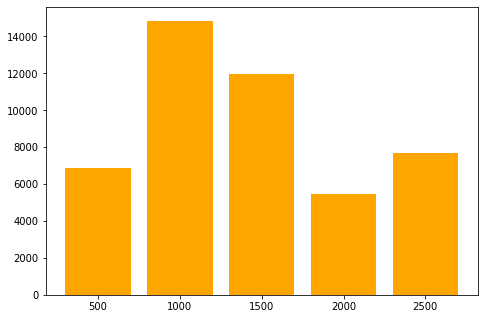

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lim = ['500', '1000', '1500', '2000', '2500']
val = [counter_0to20,counter_21to40,counter_41to60,counter_61to80,x]
ax.bar(lim,val, color = 'orange')
plt.show()

#CausalNLP

In [ ]:
!pip install -q causalnlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.2/522.2 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.2 which is incompatible.


In [ ]:
len(rules)

451

In [ ]:
sorted_rules = rules

In [ ]:
counter=0

causal_df = pd.DataFrame(columns=['Tweet ID (iloc)', 'tweet_text', 'tokenized', 'Rule No.', 'rule', 'Username', 'Is_RulePresent?', 'Is_TweetPopular?'])
# matrix_df.loc[len(matrix_df.index)] = [min_support_initialize, min_threshold_initialize, len(rules.index)] 
for i in range (0, 2598, 1): #data
  for j in range(0, 45, 1): #rules
    count=0
    is_rule_there=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      is_rule_there=1
      is_popular=1
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
    else:
      is_rule_there=0
      is_popular=1
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      


for i in range (23391, 25989, 1): #data
  for j in range(0, 45, 1): #rules
    count=0
    is_rule_there=0
    l1 = list(sorted_rules.iloc[j]['antecedents'])
    for value in l1:
      if value in sorted_df.iloc[i]:
        count=count+1
    l2 = list(sorted_rules.iloc[j]['consequents'])
    if(count==len(l1)):
      for value in l2:
        if value in sorted_df.iloc[i]:
          count=count+1
    if(count==len(l1)+len(l2)):
      is_rule_there=1
      is_popular=0
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
      # print("Tweet ", i, " contains rule number ", j)
      counter=counter+1 
    else:
      is_rule_there=0
      is_popular=0
      causal_df.loc[len(causal_df.index)] = [i, Sample_Tweets.iloc[i]['tweet'], Sample_Tweets.iloc[i]["tokenized_tweet"], j, list(sorted_rules.iloc[j]['antecedents'])+list(sorted_rules.iloc[j]['consequents']), Sample_Tweets.iloc[i]['username'], is_rule_there, is_popular]
     

In [ ]:
causal_df.to_csv('/content/drive/MyDrive/Project 2/results/ngo_who/'+'WHO-causal'+'.csv')

NameError: ignored